# Analyze performance of LSTM (Model 3) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 3 using data from Shasta reservoir.
Recall that LSTM Model 2 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. Model 3 also internally models a storage state as an input, i.e. at every timestep the previous storage is updated with the previous outflow and the current inflow. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.
4. Analyze relationship between cell states and observed storage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *
from torch.utils.data import DataLoader, TensorDataset

# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [4]:
# Run data processing pipeline
pipeline = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train, ts_val, ts_test = pipeline.process_data(df) 

In [5]:
# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
# select outflow as target feature
y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val, batch_size=1, shuffle=False))

## Analyze Optimal Hyperparameters

We conducted a small grid search around the optimal parameters of Model 1 (since the two models are similar). The search space is as follows: \
Number LSTM layers; 1\
Hidden size (LSTM): 25, 30, 35\
Hidden size (FF): 10, 15, 20\
Dropout probability: 0.3

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [6]:
# load in results from grid search
grid_df = pd.read_csv('report/results/hyperparameter_tuning/model3_tuning.csv', index_col=0)

In [7]:
# average performance over the random seeds
num_random_seeds = 5
grid_df['param_id'] = np.repeat(np.arange(int(len(grid_df) / num_random_seeds)), num_random_seeds)
grid_df_mean = grid_df.groupby('param_id').mean()
grid_df_mean.drop(columns=['random_seed'], inplace=True)

In [8]:
# save sorted df
grid_df_mean.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean.to_csv('report/results/hyperparameter_tuning/model1_avg_tuning.csv')
grid_df_mean[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
7,1.0,35.0,15.0,0.3,46.8,0.393087
4,1.0,30.0,15.0,0.3,36.8,0.409948
3,1.0,30.0,10.0,0.3,40.0,0.415640
8,1.0,35.0,20.0,0.3,34.0,0.416180
5,1.0,30.0,20.0,0.3,35.2,0.419998
1,1.0,25.0,15.0,0.3,41.8,0.427073
0,1.0,25.0,10.0,0.3,36.6,0.442767
2,1.0,25.0,20.0,0.3,33.8,0.444462
6,1.0,35.0,10.0,0.3,43.4,0.445533


### Load model with optimal hyperparaeters

The optimal hyperparameters are:
Number  of LSTM layers: 1\
LSTM hidden units: 35\
FF hidden units: 15\
dropout: 0.3

In [9]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *

In [10]:
# instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model3 = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)

In [11]:
# load saved model parameters
model3.load_state_dict(torch.load('src/models/saved_models/model3.pt'))

<All keys matched successfully>

## Evaluate Model 3

In [12]:
from src.models.predict_model import *
from sklearn.metrics import r2_score

In [13]:
model3.eval()

LSTMModel3(
  (lstm_cell): LSTMCell(3, 35)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=35, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

### In training

In [15]:
# flatten and remove pads
y_hat_train, y_true_train = flatten_rm_pad(y_hat=model3(X_train)[0].detach(), y=y_train)

# check dimensions of datetime
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

assert len(y_true_train) == original_train_len

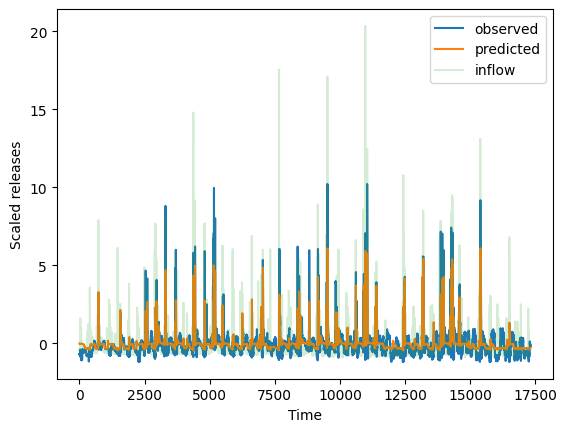

In [16]:
plot_predicted_true(y_hat=y_hat_train, y=y_true_train)
plt.plot(((df.inflow[:(original_train_len)] - df.inflow[:(original_train_len)].mean()) / df.inflow[:(original_train_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [17]:
# R-squared
r2_score(y_true=y_true_train, y_pred=y_hat_train)

0.6667791528725486

### In testing...

In [19]:
# flatten and remove pads
y_hat_test, y_true_test = flatten_rm_pad(y_hat=model3(X_test)[0].detach(), y=y_test)
# check dimensions
assert len(y_true_test) == len(df.index) - (original_train_len + original_val_len)

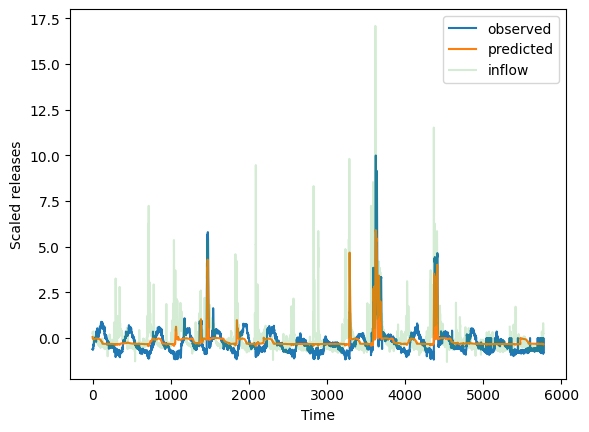

In [20]:
plot_predicted_true(y_hat=y_hat_test, y=y_true_test)
plt.plot(((df.inflow[(original_train_len+original_val_len):] - df.inflow[(original_train_len+original_val_len):].mean()) / df.inflow[(original_train_len+original_val_len):].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [21]:
# R-squared
r2_score(y_true=y_true_test, y_pred=y_hat_test)

0.5551520726816488

### In validation...

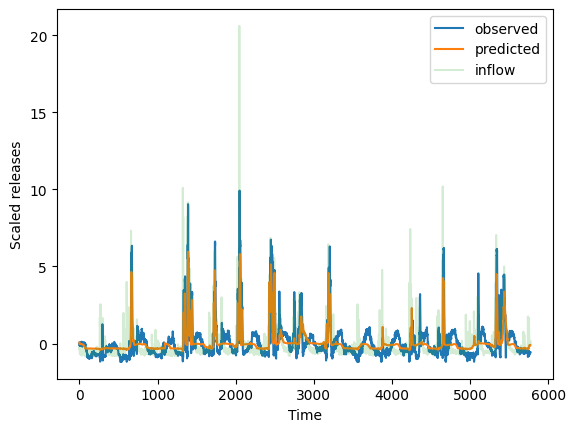

In [23]:
y_hat_val, y_true_val = flatten_rm_pad(y_hat=model3(X_val)[0].detach(), y=y_val)
assert len(y_true_val) == original_val_len

plot_predicted_true(y_hat=y_hat_val, y=y_true_val)
plt.plot(((df.inflow[original_train_len:(original_train_len+original_val_len)] - df.inflow[original_train_len:(original_train_len+original_val_len)].mean()) / df.inflow[original_train_len:(original_train_len+original_val_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [24]:
r2_score(y_true_val, y_hat_val)

0.6539722272812286

## Analyze implied storage states

### Analyze correlations

In [25]:
from src.models.analyze_lstm_cell import *

In [26]:
# Get cell states, shape is (# chunks, timesteps, hidden size)
im_storage_train = model3(X_train)[1].detach()
im_storage_val = model3(X_val)[1].detach()
im_storage_test = model3(X_test)[1].detach()

In [27]:
# Get observed storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

In [28]:
correlation_data = {'training':cell_correlations(cell_states=im_storage_train, storage_states=storage_train),
                    'validation': cell_correlations(cell_states=im_storage_val, storage_states=storage_val),
                    'testing': cell_correlations(cell_states=im_storage_test, storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)

In [29]:
df_corr

,training,validation,testing
0,0.807539,0.818816,0.861099


### Plot implied storage vs observed storage

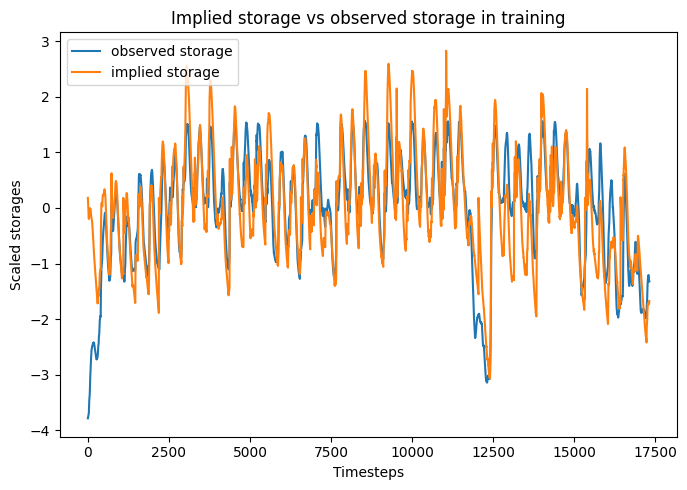

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), sharex=True)
plot_storage_cell(cell_states_all=im_storage_train, storage_states=storage_train, cell_id=0, ax=axes)
axes.legend(['observed storage', 'implied storage'], loc='upper left')
axes.set_title('Implied storage vs observed storage in training')
axes.set_xlabel('Timesteps')
axes.set_ylabel('Scaled storages')
plt.tight_layout()
plt.show()

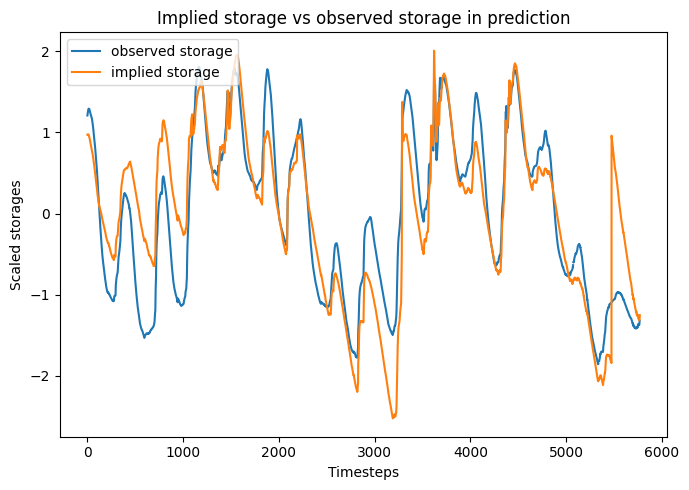

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), sharex=True)
plot_storage_cell(cell_states_all=im_storage_test, storage_states=storage_test, cell_id=0, ax=axes)
axes.legend(['observed storage', 'implied storage'], loc='upper left')
axes.set_title('Implied storage vs observed storage in prediction')
axes.set_xlabel('Timesteps')
axes.set_ylabel('Scaled storages')
plt.tight_layout()
plt.show()

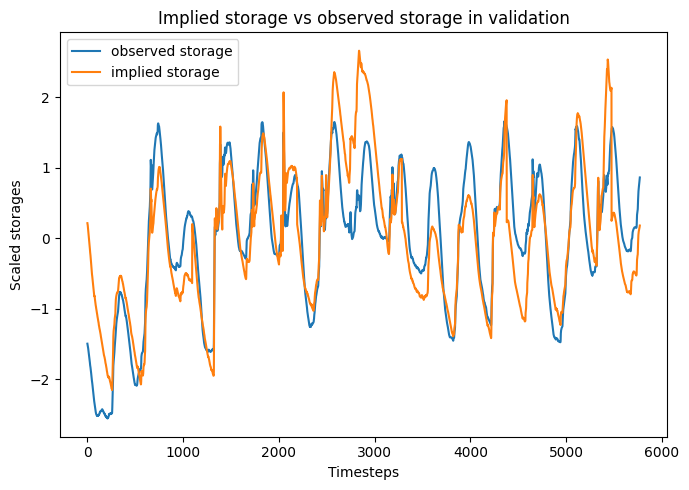

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), sharex=True)
plot_storage_cell(cell_states_all=im_storage_val, storage_states=storage_val, cell_id=0, ax=axes)
axes.legend(['observed storage', 'implied storage'], loc='upper left')
axes.set_title('Implied storage vs observed storage in validation')
axes.set_xlabel('Timesteps')
axes.set_ylabel('Scaled storages')
plt.tight_layout()
plt.show()

Notes: unlike Model 1 and Model 2, it appears that Model 3 no longer makes decisions about peaks based on peak inflows. However, the model tends to make poor decisions when it comes to seasonal (non peak) releases.